<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Profiling and Scaling Analysis of the NetworkSedimentTransporter

Part 1: Do some stuff to give us generic, variable sized grids and parcels. 
Part 2: Do some profiling. 
Part 2: Do some scaling analysis.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph

import cProfile
import pstats
from pstats import SortKey
import io

import xarray as xr

import pandas as pd
import time

## Part 1: Variably-sized grids and parcels

### Part 1a: Grids

First, we need the ability to create different sizes of grids. 

A simple approach is to create a generic grid in which each node has two recievers. Lets start by writing a function that creates the x and y node coordinates and the linking structure for a given number of layers.   

I haven't tried to optimize this at all. 

In [2]:
def create_node_xy_and_links(n_layers, x0=0., y0=0., xperc=0.9, dy=1.):
    assert xperc<1.0
    nodes_per_layer = np.power(2, np.arange(n_layers+1))
    nnodes = np.sum(nodes_per_layer)   
    x_of_node=[x0]
    y_of_node=[y0]
    nodes_at_link = []
    id_start_layer = 0
    for nl in np.arange(1, n_layers+1):
        nodes_last_layer = np.power(2, nl-1)
        nodes_this_layer = np.power(2, nl)              
        dx = xperc * (dy)*(0.5**(nl-1))
        for ni in range(nodes_last_layer):
            head_id = id_start_layer+ni            
            tail_id = len(x_of_node)           
            x = x_of_node[head_id]
            y = y_of_node[head_id]            
            x_of_node.extend([x-dx, x+dx])
            y_of_node.extend([y+dy, y+dy])            
            nodes_at_link.extend([(head_id, tail_id), (head_id, tail_id +1)])   
        id_start_layer = len(x_of_node) - nodes_this_layer
    return x_of_node, y_of_node, nodes_at_link

Lets demonstrate the different sorts of grids we get with different numbers of layers

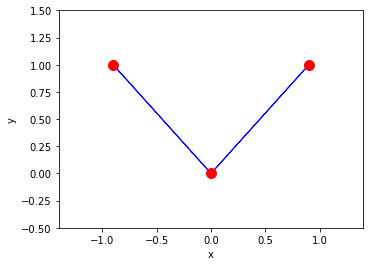

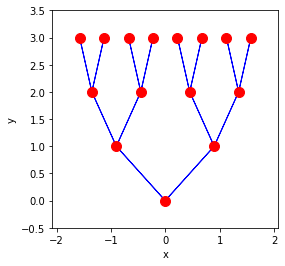

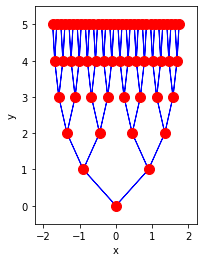

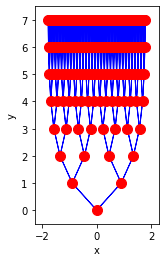

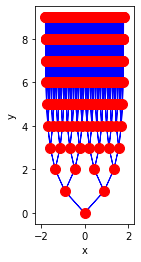

In [3]:
example_layers = [1, 3, 5, 7, 9]

nodes = []
for i, n_layers in enumerate(example_layers):
    x_of_node, y_of_node, nodes_at_link = create_node_xy_and_links(n_layers)
    grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

    graph.plot_graph(grid, at="node,link", with_id=False)
    nodes.append(grid.number_of_nodes)

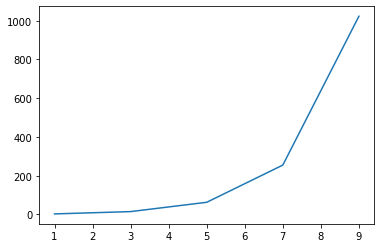

In [4]:
plt.plot(example_layers, nodes)

### 1b: Generic grid.

The grid needs some additional fields added to it...

In [5]:
def create_nmg_and_fd(n_layers):
    x_of_node, y_of_node, nodes_at_link = create_node_xy_and_links(n_layers)
    grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

    _ = grid.add_field("topographic__elevation", grid.y_of_node.copy(), at="node")
    _ = grid.add_field("bedrock__elevation", grid.y_of_node.copy(), at="node")
    _ = grid.add_field("flow_depth", 2.5*np.ones(grid.number_of_links), at="link")  # m
    _ = grid.add_field("reach_length", 200.*np.ones(grid.number_of_links), at="link")  # m
    _ = grid.add_field("channel_width", 1.*np.ones(grid.number_of_links), at="link")  # m
    
    fd = FlowDirectorSteepest(grid)
    fd.run_one_step()
    return grid, fd

### 1c: Generic sets of parcels
A real application would likley use 50k+ parcels (b/c you want the full gsd) and 100-500 links in the network. 
You typically want at least 100 parcels per link. 

In [6]:
def create_parcels(grid, parcels_per_link=5):

    # element_id is the link on which the parcel begins. 
    element_id = np.repeat(np.arange(grid.number_of_links), parcels_per_link)
    element_id = np.expand_dims(element_id, axis=1)

    # scale volume with parcels per link so we end up with a similar quantity of sediment. 
    volume = (1./parcels_per_link) * np.ones(np.shape(element_id))  # (m3)
    
    active_layer = np.zeros(np.shape(element_id)) # 1= active, 0 = inactive
    density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
    abrasion_rate = 0. * np.ones(np.size(element_id)) # (mass loss /m)

    # Lognormal GSD
    medianD = 0.085 # m
    mu = np.log(medianD)
    sigma = np.log(2) #assume that D84 = sigma*D50
    np.random.seed(0)
    D = np.random.lognormal(
        mu,
        sigma,
        np.shape(element_id)
    )  # (m) the diameter of grains in each parcel

    time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
    location_in_link = np.random.rand(np.size(element_id), 1) 

    variables = {
        "abrasion_rate": (["item_id"], abrasion_rate),
        "density": (["item_id"], density),
        "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
        "active_layer": (["item_id", "time"], active_layer),
        "location_in_link": (["item_id", "time"], location_in_link),
        "D": (["item_id", "time"], D),
        "volume": (["item_id", "time"], volume)
    }


    items = {"grid_element": "link", "element_id": element_id}

    parcels = DataRecord(
        grid,
        items=items,
        time=[0.0],
        data_vars=variables,
        dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
    )

    return parcels

In [7]:
def create_all(nlayer=3, parcels_per_link=100, timesteps=10):

    grid, fd = create_nmg_and_fd(nlayer)

    parcels = create_parcels(grid, parcels_per_link=parcels_per_link)

    dt = 60 * 60 * 24 *12 # length of timestep (seconds) 
    
    return grid, fd, parcels, dt, timesteps

In [8]:
np.random.seed(1234)

grid, fd, parcels, dt, timesteps = create_all(nlayer=4, parcels_per_link=50, timesteps=60)

nst = NetworkSedimentTransporter(    
    grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

pr = cProfile.Profile()
pr.enable()
for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)
pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
#print(s.getvalue())

#with open("profile.txt", "w") as f:
#    f.write(s.getvalue())

In [9]:
def profile_code(nlayer=3, parcels_per_link=100, timesteps=10):

    grid, fd = create_nmg_and_fd(nlayer)

    parcels = create_parcels(grid, parcels_per_link=parcels_per_link)

    dt = 60 * 60 * 24 *12 # length of timestep (seconds) 

    init_start = time.time()
    nst = NetworkSedimentTransporter(    
        grid,
        parcels,
        fd,
        bed_porosity=0.3,
        g=9.81,
        fluid_density=1000,
        transport_method="WilcockCrowe",
    )
    init_duration = time.time() - init_start

    if timesteps >0:
        r1s_start = time.time()
        for t in range(timesteps):
            nst.run_one_step(dt)
        r1s_per = (time.time() - r1s_start) / timesteps
    else: 
        r1s_per = 0.0

    return (grid.number_of_nodes, parcels_per_link, timesteps), init_duration, r1s_per

In [10]:
np.random.seed(345)

out = []
# this range for i in reduced for testing. 
for i in range(2, 5):
    for j in [10, 20, 50, 100, 200, 500]:
        print(i, j)
        (nn, ppl, ts), init, r1s_per = profile_code(
            nlayer=i, 
            parcels_per_link=j, 
            timesteps=10)
        out.append((nn, ppl, init, r1s_per))

2 10
2 20
2 50
2 100
2 200
2 500
3 10
3 20
3 50
3 100
3 200
3 500
4 10
4 20
4 50
4 100
4 200
4 500


In [11]:
df = pd.DataFrame(out, columns=["nnodes", "ppl", "init", 'r1s_per'])
df = df.pivot(index='ppl', columns='nnodes', values=["init", 'r1s_per'])
df.head()

init                       r1s_per                    
nnodes        7         15        31        7         15        31
ppl                                                               
10      0.076296  0.099531  0.187141  0.044310  0.063488  0.095898
20      0.055714  0.121907  0.193039  0.045293  0.071059  0.109831
50      0.060194  0.121842  0.199429  0.052580  0.081600  0.136634
100     0.059619  0.107185  0.202358  0.057082  0.094476  0.164489
200     0.064496  0.117313  0.228310  0.067203  0.112097  0.208309

Text(0.5, 0, 'parcels per link')

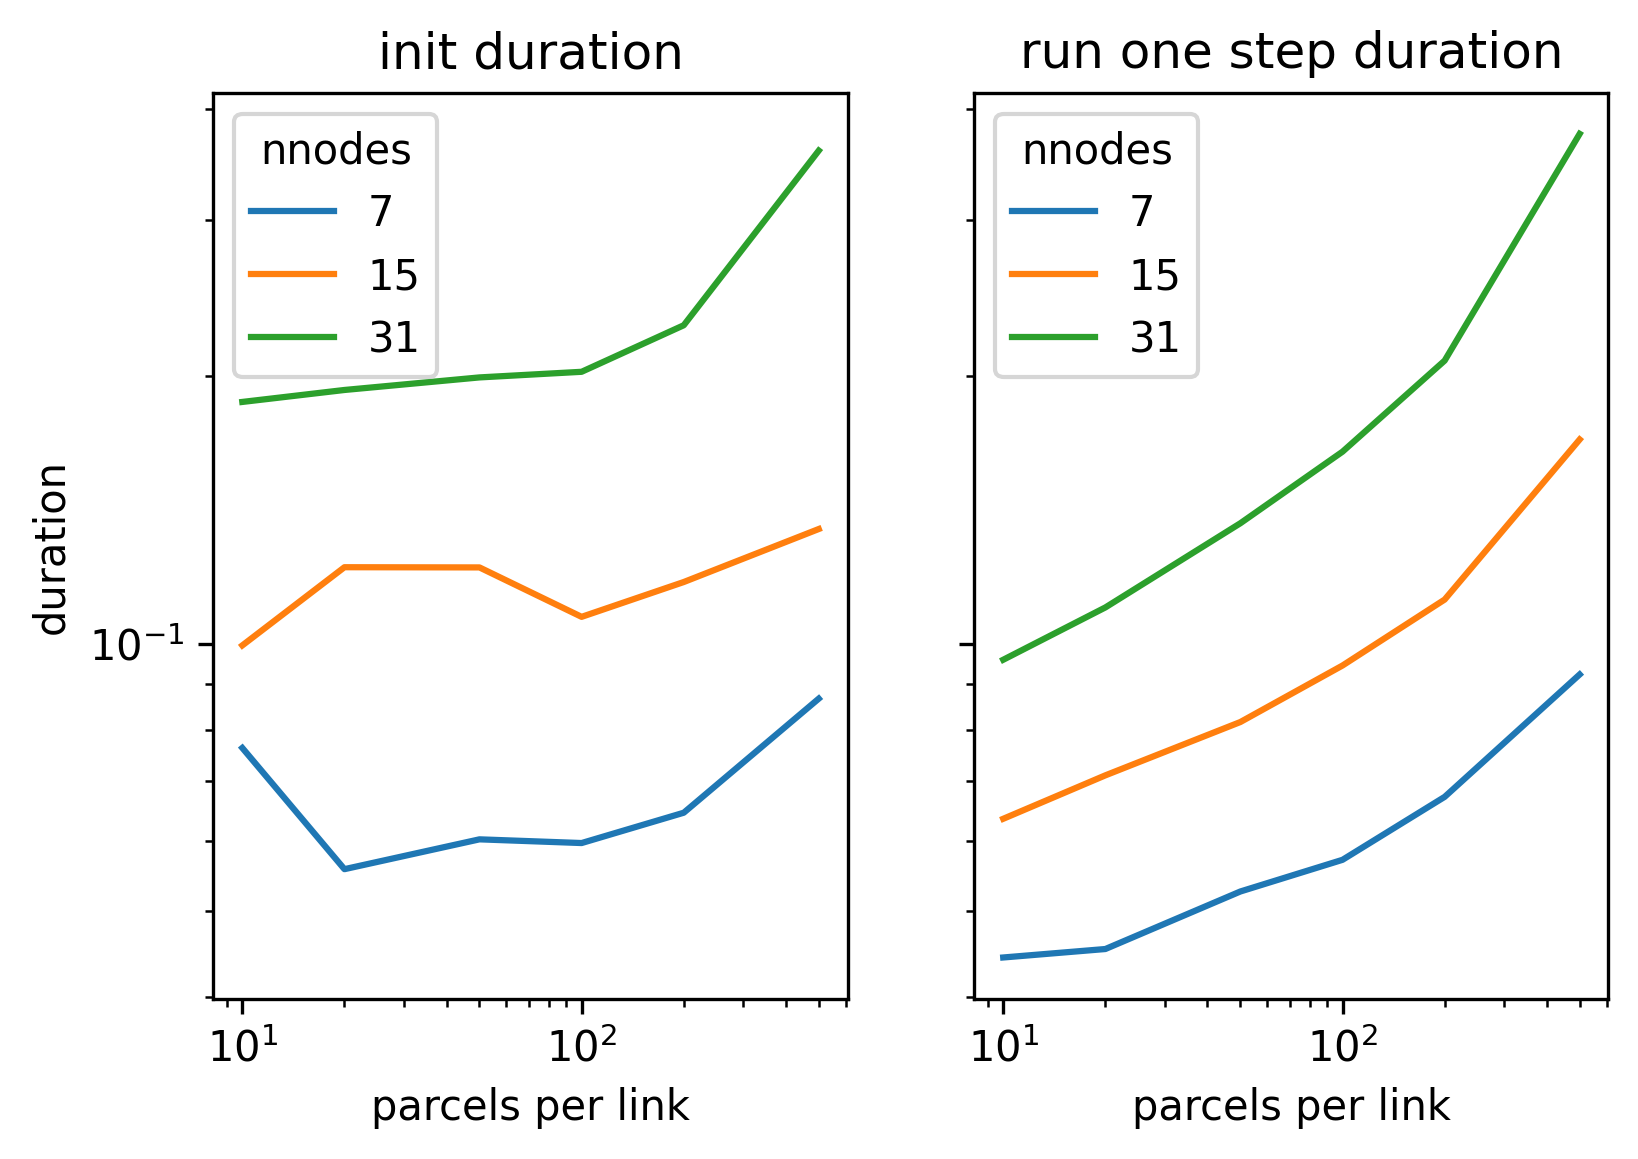

In [12]:
df = pd.DataFrame(out, columns=["nnodes", "ppl", "init", 'r1s_per'])
df = df.pivot(index='ppl', columns='nnodes', values=["init", 'r1s_per'])

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, dpi=300)

df["init"].plot(loglog=True, ax=ax[0], title="init duration")
ax[0].set_ylabel("duration")
ax[0].set_xlabel("parcels per link")

df["r1s_per"].plot(loglog=True, ax=ax[1], title="run one step duration")
ax[1].set_ylabel("duration")
ax[1].set_xlabel("parcels per link")
#plt.savefig("scaling1.png")

Text(0.5, 0, 'Number of Nodes')

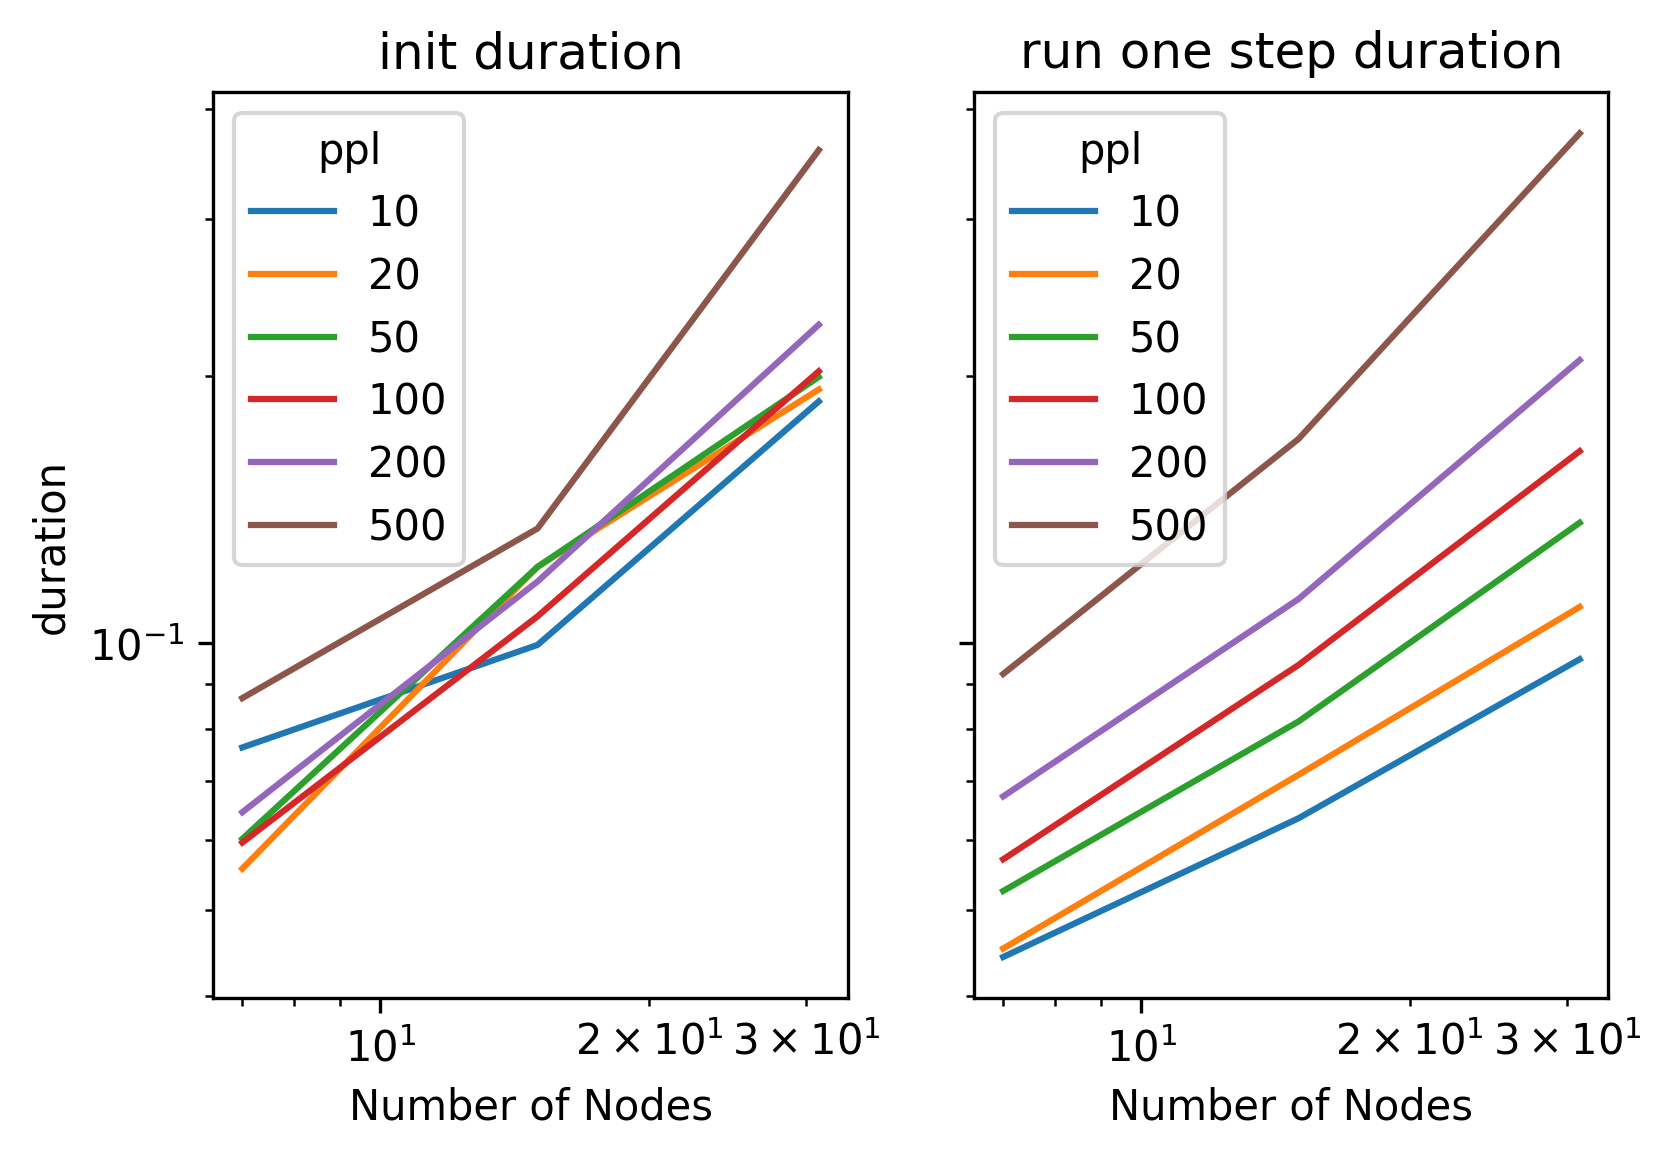

In [13]:
df = pd.DataFrame(out, columns=["nnodes", "ppl", "init", 'r1s_per'])
df = df.pivot(index='nnodes', columns='ppl', values=["init", 'r1s_per'])
df.head()

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, dpi=300)

df["init"].plot(loglog=True, ax=ax[0], title="init duration")
ax[0].set_ylabel("duration")
ax[0].set_xlabel("Number of Nodes")

df["r1s_per"].plot(loglog=True, ax=ax[1], title="run one step duration")
ax[1].set_ylabel("duration")
ax[1].set_xlabel("Number of Nodes")
#plt.savefig("scaling1.png")